<a href="https://colab.research.google.com/github/PriyaMurali/Data-Analysis/blob/main/ETLTelecomm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from collections import Counter
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

In [2]:
!apt-get update
!apt-get install --fix-missing openjdk-8-jdk-headless -qq > /dev/null


Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [3,368 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates/restricted amd64 Packages [1,141 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [2,310 kB]
Ign:13 https://developer.download.nvidia.com/compute/m

In [3]:
'''!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version'''

'!apt-get install openjdk-8-jdk-headless -qq > /dev/null\nimport os\nos.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"\n!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java\n!java -version'

In [30]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, initcap  # Some functions that later will be useful

spark = SparkSession \
        .builder \
        .appName("PySparkETLTelecom") \
        .getOrCreate()

In [7]:
# Load Datafiles
provincesDF = spark.read.load("/content/sample_data/Italian_provinces.geojson",
                    format='json',
                    multiline=True,
                    inferSchema='true').cache()
provincesDF

DataFrame[crs: struct<properties:struct<name:string>,type:string>, features: array<struct<geometry:struct<coordinates:array<array<array<array<double>>>>,type:string>,properties:struct<PROVINCIA:string,SHAPE_AREA:double,SIGLA:string>,type:string>>, type: string]

In [8]:
provincesDF.printSchema()

root
 |-- crs: struct (nullable = true)
 |    |-- properties: struct (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |-- type: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- geometry: struct (nullable = true)
 |    |    |    |-- coordinates: array (nullable = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |    |-- type: string (nullable = true)
 |    |    |-- properties: struct (nullable = true)
 |    |    |    |-- PROVINCIA: string (nullable = true)
 |    |    |    |-- SHAPE_AREA: double (nullable = true)
 |    |    |    |-- SIGLA: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- type: string (nullable = true)



In [9]:
provincesDF = provincesDF.select("features.properties.PROVINCIA")
provincesDF.show()

+--------------------+
|           PROVINCIA|
+--------------------+
|[Novara, Torino, ...|
+--------------------+



In [10]:
provincesDF = provincesDF.select(explode("PROVINCIA")).withColumnRenamed("col", "PROVINCIA")
provincesDF.show(5)

+-----------+
|  PROVINCIA|
+-----------+
|     Novara|
|     Torino|
|   Vercelli|
|      Aosta|
|Alessandria|
+-----------+
only showing top 5 rows



In [11]:
provincesDF.createOrReplaceTempView("provincesDF")
spark.sql("show tables").show()


+---------+-----------+-----------+
|namespace|  tableName|isTemporary|
+---------+-----------+-----------+
|         |provincesdf|       true|
+---------+-----------+-----------+



In [12]:
provincesDF.write.mode("overwrite") \
            .format('parquet') \
            .save('/content/sample_data/provinces.parquet')

In [13]:
cdrDF = spark.read.load("/content/sample_data/sms-call-internet-mi-2013-11-01.csv",
                    format='csv',
                    sep = ',',
                    header='true',
                    inferSchema='true').cache()
cdrDF.show(5)


+-------------------+------+-----------+------+------+------+-------+--------+
|           datetime|CellID|countrycode| smsin|smsout|callin|callout|internet|
+-------------------+------+-----------+------+------+------+-------+--------+
|2013-11-01 00:00:00|     1|          0|0.3521|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     1|         33|  null|  null|  null|   null|  0.0261|
|2013-11-01 00:00:00|     1|         39|1.7322|1.1047|0.5919|  0.402| 57.7729|
|2013-11-01 00:00:00|     2|          0|0.3581|  null|  null| 0.0273|    null|
|2013-11-01 00:00:00|     2|         33|  null|  null|  null|   null|  0.0274|
+-------------------+------+-----------+------+------+------+-------+--------+
only showing top 5 rows



In [15]:
#Data Cleaning

cdrDF = cdrDF.na.fill(0)
cdrDF.show(5)


+-------------------+------+-----------+------+------+------+-------+--------+
|           datetime|CellID|countrycode| smsin|smsout|callin|callout|internet|
+-------------------+------+-----------+------+------+------+-------+--------+
|2013-11-01 00:00:00|     1|          0|0.3521|   0.0|   0.0| 0.0273|     0.0|
|2013-11-01 00:00:00|     1|         33|   0.0|   0.0|   0.0|    0.0|  0.0261|
|2013-11-01 00:00:00|     1|         39|1.7322|1.1047|0.5919|  0.402| 57.7729|
|2013-11-01 00:00:00|     2|          0|0.3581|   0.0|   0.0| 0.0273|     0.0|
|2013-11-01 00:00:00|     2|         33|   0.0|   0.0|   0.0|    0.0|  0.0274|
+-------------------+------+-----------+------+------+------+-------+--------+
only showing top 5 rows



In [16]:
cdrDF.createOrReplaceTempView("cdr")


In [17]:
spark.sql("show tables").show()


+---------+-----------+-----------+
|namespace|  tableName|isTemporary|
+---------+-----------+-----------+
|         |        cdr|       true|
|         |provincesdf|       true|
+---------+-----------+-----------+



In [18]:
aggcountryDF = spark.sql("""select 
                                CASE countrycode
                                    WHEN 7 THEN "Russia"
                                    WHEN 33 THEN "France"
                                    WHEN 34 THEN "Spain"
                                    WHEN 39 THEN "Italy"
                                    WHEN 44 THEN "United Kingdom"
                                    WHEN 47 THEN "Norway"
                                    WHEN 48 THEN "Poland"
                                    WHEN 49 THEN "Germany"
                                    WHEN 351 THEN "Portugal"
                                    WHEN 420 THEN "Czech Republic"
                                    ELSE "_Others_"
                                END as country,
                                round(sum(smsin),6) smsin, 
                                round(sum(smsout),6) smsout, 
                                round(sum(callin),6) callin, 
                                round(sum(callout),6) callout, 
                                round(sum(internet),6) internet
                            from cdr
                            where countrycode != 0
                            group by country
                            order by 1
                            """)

In [19]:
aggcountryDF.show()


+--------------+-----------+-----------+-----------+-----------+--------------+
|       country|      smsin|     smsout|     callin|    callout|      internet|
+--------------+-----------+-----------+-----------+-----------+--------------+
|Czech Republic|   589.1084|   384.9712|   186.5715|   132.6839|     4552.1083|
|        France|  4593.0272|  2836.3753|  1005.5086|   741.6321|    11680.9966|
|       Germany|  3035.3655|   900.3133|   390.2487|   351.0411|     6903.0869|
|         Italy|872654.8902|895131.4939|657772.4881|795643.4362|3.2159256055E7|
|        Norway|   138.2382|    87.5495|    20.3952|    42.7664|      473.1804|
|        Poland|   835.0364|   403.2474|   282.4475|   226.1809|      903.3277|
|      Portugal|   143.6029|    84.8865|    46.4828|    32.1197|      157.3614|
|        Russia|  2685.2049|  1868.3432|  1837.1902|    578.716|     1513.0446|
|         Spain|   511.5122|   351.4705|   423.7304|   269.8687|     2874.6817|
|United Kingdom|  2813.0149|  2599.7815|

In [20]:
#Write file to Parquet format
aggcountryDF.write.mode("overwrite") \
            .format('parquet') \
            .save('/content/sample_data/AggregatedCountries.parquet')

In [21]:
spark.sql("SELECT upper(PROVINCIA) as Province FROM parquet.`/content/sample_data/provinces.parquet`").show(3)
spark.read.load("/content/sample_data/provinces.parquet", format='parquet').show(3)

+--------+
|Province|
+--------+
|  NOVARA|
|  TORINO|
|VERCELLI|
+--------+
only showing top 3 rows

+---------+
|PROVINCIA|
+---------+
|   Novara|
|   Torino|
| Vercelli|
+---------+
only showing top 3 rows



In [22]:
#Using MATPLOTLIB for VISUALIZATION

import matplotlib.pyplot as plt
import numpy as np

In [23]:
plotdf = aggcountryDF.where("country not in ('Italy','_Others_')").toPandas()
print(plotdf)

          country      smsin     smsout     callin   callout    internet
0  Czech Republic   589.1084   384.9712   186.5715  132.6839   4552.1083
1          France  4593.0272  2836.3753  1005.5086  741.6321  11680.9966
2         Germany  3035.3655   900.3133   390.2487  351.0411   6903.0869
3          Norway   138.2382    87.5495    20.3952   42.7664    473.1804
4          Poland   835.0364   403.2474   282.4475  226.1809    903.3277
5        Portugal   143.6029    84.8865    46.4828   32.1197    157.3614
6          Russia  2685.2049  1868.3432  1837.1902  578.7160   1513.0446
7           Spain   511.5122   351.4705   423.7304  269.8687   2874.6817
8  United Kingdom  2813.0149  2599.7815   836.2897  545.0998   6374.1321


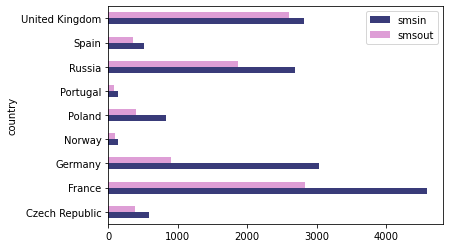

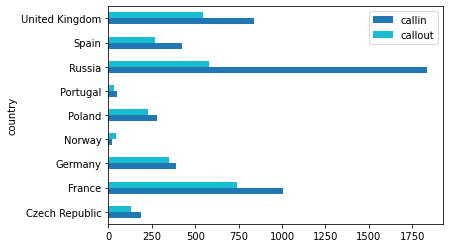

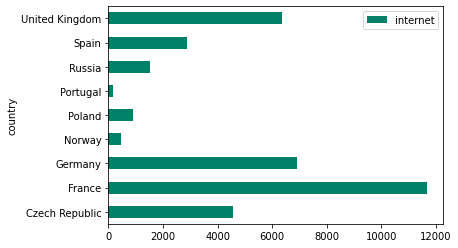

In [24]:
plotdf.plot(kind='barh', x='country', y=['smsin', 'smsout'], colormap='tab20b')
plotdf.plot(kind='barh', x='country', y=['callin', 'callout'], colormap='tab10')
plotdf.plot(kind='barh', x='country', y=['internet'], colormap='summer')

**RDD Joins and Operations**

In [31]:
sc = spark.sparkContext
#import tables as RDD
DimEmployee = sc.textFile("/content/sample_data/DimEmployee.csv")
FactResellerSales = sc.textFile("/content/sample_data/FactResellerSales.csv")
#split data based on delimiter
DimEmployee = DimEmployee.map(lambda var1: var1.split(","))
FactResellerSales = FactResellerSales.map(lambda var1: var1.split(","))
#convert data in-terms of key-value pairs where the key is the column to be joined
DimEmployee = DimEmployee.map(lambda var1: [var1[0],[var1[1],var1[2],var1[3]]])
FactResellerSales = FactResellerSales.map(lambda var1: [var1[5], [var1[0], var1[1], var1[2], var1[3], var1[4], var1[5], var1[6], var1[7], float(var1[8]), float(var1[9]),float(var1[10]),float(var1[11]), float(var1[12]), float(var1[13]), float(var1[14]), float(var1[15])]])
#perform join
RF = FactResellerSales.join(DimEmployee)
#print contents of joins
RF.take(10)
#extract first RDD values along with the key
print(RF.map(lambda var1: (var1[0],var1[1][0])).take(4))


[('283', ['363', '20080101', '20080113', '20080108', '594', '283', '1', '2', 3.0, 1376.994, 0.0, 0.0, 1251.9813, 3755.9439, 4130.982, 103.2746]), ('283', ['483', '20080301', '20080313', '20080308', '90', '283', '1', '5', 4.0, 72.0, 0.0, 0.0, 44.88, 179.52, 288.0, 7.2]), ('283', ['381', '20070201', '20070213', '20070208', '666', '283', '1', '2', 1.0, 600.2625, 0.0, 0.0, 605.6492, 605.6492, 600.2625, 15.0066]), ('283', ['454', '20060901', '20060913', '20060908', '130', '283', '1', '4', 4.0, 35.994, 0.0, 0.0, 24.7459, 98.9836, 143.976, 3.5994])]


In [32]:
DimEmp = spark.read.load("/content/DimEmployee.csv",
                         format='csv',
                         sep = ',',
                         header='true',
                         inferSchema='true').cache()
DimEmp.show()
print("No.of Records in EmployeeTable: ",DimEmp.count())


+-----------+-----------------+-----------------+---------+
|EmployeeKey|ParentEmployeeKey|SalesTerritoryKey|FirstName|
+-----------+-----------------+-----------------+---------+
|         72|               32|               11|     Ajay|
|         36|               87|               11|  Hemanth|
|        104|               16|               11|   Ganesh|
|        120|               44|               11|  Perumal|
|        287|              272|                4|      Shu|
|        105|               44|               11|      Dan|
|        201|               23|               11|     Lori|
|        130|               92|               11|     Sean|
|        295|              290|                8|   Rachel|
|        216|               92|               11|    Chris|
|        285|              272|                5|     Tsvi|
|         59|               18|               11|    Annik|
|         69|               16|               11|      Bob|
|         83|              214|         

In [33]:
print(DimEmp.distinct().show())

+-----------+-----------------+-----------------+-----------+
|EmployeeKey|ParentEmployeeKey|SalesTerritoryKey|  FirstName|
+-----------+-----------------+-----------------+-----------+
|        252|               27|               11|Christopher|
|        276|                7|               11|       Mary|
|        169|               76|               11|     Sameer|
|         14|              112|               11|      Terri|
|        222|              152|               11|       Gary|
|        262|              111|               11|     Olinda|
|        109|                7|               11|       Mary|
|        258|               20|               11|    Michael|
|        284|              272|                6|    Garrett|
|         34|              188|               11|    Garrett|
|        282|              272|                4|      Linda|
|        202|              278|               11|     Arvind|
|        247|               20|               11|     Maciej|
|       

In [34]:
FactReseller = spark.read.load("/content/FactResellerSales.csv",
                              format='csv',
                              sep = ',',
                              header='true',
                              inferSchema='true').cache()
FactReseller.show()

+----------+------------+----------+-----------+-----------+-----------+------------+-----------------+-------------+---------+--------------------+--------------+-------------------+----------------+-----------+--------+
|ProductKey|OrderDateKey|DueDateKey|ShipDateKey|ResellerKey|EmployeeKey|PromotionKey|SalesTerritoryKey|OrderQuantity|UnitPrice|UnitPriceDiscountPct|DiscountAmount|ProductStandardCost|TotalProductCost|SalesAmount| Freight|
+----------+------------+----------+-----------+-----------+-----------+------------+-----------------+-------------+---------+--------------------+--------------+-------------------+----------------+-----------+--------+
|       339|    20070401|  20070413|   20070408|        523|        282|           1|                3|            2|  469.794|                 0.0|           0.0|           486.7066|        973.4132|    939.588| 23.4897|
|       213|    20060801|  20060813|   20060808|        403|        282|           1|                4|         

In [35]:
factFilter=FactReseller.filter("SalesTerritoryKey=='8'")
factFilter.show()

+----------+------------+----------+-----------+-----------+-----------+------------+-----------------+-------------+---------+--------------------+--------------+-------------------+----------------+-----------+--------+
|ProductKey|OrderDateKey|DueDateKey|ShipDateKey|ResellerKey|EmployeeKey|PromotionKey|SalesTerritoryKey|OrderQuantity|UnitPrice|UnitPriceDiscountPct|DiscountAmount|ProductStandardCost|TotalProductCost|SalesAmount| Freight|
+----------+------------+----------+-----------+-----------+-----------+------------+-----------------+-------------+---------+--------------------+--------------+-------------------+----------------+-----------+--------+
|       214|    20080201|  20080213|   20080208|        230|        295|           1|                8|            6|   20.994|                 0.0|           0.0|            13.0863|         78.5178|    125.964|  3.1491|
|       463|    20071001|  20071013|   20071008|        302|        295|           1|                8|         

In [36]:
factjoin = DimEmp.join(FactReseller,DimEmp['EmployeeKey']==FactReseller['EmployeeKey'])
factjoin.show()

+-----------+-----------------+-----------------+---------+----------+------------+----------+-----------+-----------+-----------+------------+-----------------+-------------+---------+--------------------+--------------+-------------------+----------------+-----------+--------+
|EmployeeKey|ParentEmployeeKey|SalesTerritoryKey|FirstName|ProductKey|OrderDateKey|DueDateKey|ShipDateKey|ResellerKey|EmployeeKey|PromotionKey|SalesTerritoryKey|OrderQuantity|UnitPrice|UnitPriceDiscountPct|DiscountAmount|ProductStandardCost|TotalProductCost|SalesAmount| Freight|
+-----------+-----------------+-----------------+---------+----------+------------+----------+-----------+-----------+-----------+------------+-----------------+-------------+---------+--------------------+--------------+-------------------+----------------+-----------+--------+
|        282|              272|                4|    Linda|       339|    20070401|  20070413|   20070408|        523|        282|           1|                3